In [ ]:
FRAMES_DIR = '/content/frames/'
ALIGNED_FRAMES_DIR = '/content/aligned-frames/'
ORIGINAL_VIDEO_NAME = 'trimmed.mp4'
RESIZED_VIDEO_NAME = 'resized.mp4'  # set equal to ORIGINAL_VIDEO_NAME to avoid resizing 

In [ ]:
# Uncomment and run to remove all previous data.
!rm -rf ./frames/ ./aligned* sound.mp3 $RESIZED_VIDEO_NAME
# !rm $ORIGINAL_VIDEO_NAME 

In [ ]:
if ORIGINAL_VIDEO_NAME != RESIZED_VIDEO_NAME:
    # Resize the input video (reduce width and height by half). Read more about 
    # scaling here: https://trac.ffmpeg.org/wiki/Scaling
    !ffmpeg -i $ORIGINAL_VIDEO_NAME -vf scale=iw/2:ih/2 $RESIZED_VIDEO_NAME

# Another option: scale to 320xN pixels (N inferred automatically).
# !ffmpeg -i /content/$ORIGINAL_VIDEO_NAME -vf scale=320:-1 $RESIZED_VIDEO_NAME

In [ ]:
!mkdir -p $FRAMES_DIR $ALIGNED_FRAMES_DIR  # create dirs for frames
!ffmpeg -i $RESIZED_VIDEO_NAME ./frames/frame-%05d.png  # extract all frames from the video
!ffmpeg -i $RESIZED_VIDEO_NAME -c:a libmp3lame sound.mp3  #  extract sound from the video

In [ ]:
!pip install -q face-alignment  # remove -q flag to see verbose output

In [ ]:
import face_alignment
import cv2
from skimage import io
from skimage.transform import resize
import os
import time

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
# Get a list of frame files.
images = sorted(os.listdir(FRAMES_DIR))
images = [image for image in images if image.endswith('.png')]  # filter the list so that only images are left

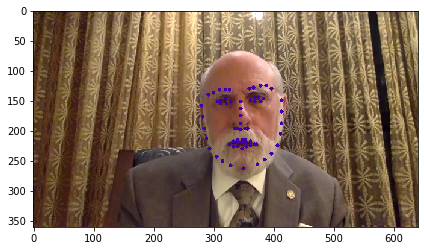

In [ ]:
LANDMARKS_SIZE = 3  # size of plotted landmarks
LANDMARKS_COLOR_RGB = (64, 0, 168)

# Detect landmarks for the first frame and plot them. This is done in order to
# check visually if landmarks size is ok.
image = io.imread(os.path.join(FRAMES_DIR, images[0]))
landmarks = fa.get_landmarks(image)

if landmarks is not None:  # could be None if no faces were found on a particular frame (also raises a warning in the output)
    # Draw the landmarks on the image.
    for (x, y) in landmarks[0]:
        cv2.circle(image, (x, y), LANDMARKS_SIZE, LANDMARKS_COLOR_RGB, -1)  

io.imshow(image)

In [ ]:
# Align all frames (i.e. get landmarks for each frame and plot them on that frame).
print(f'processing {len(images)} frames...')
start_time = time.time()  # for computing elapsed time

for image_name in images:
    print(f'aligning {image_name}...')
    image = io.imread(os.path.join(FRAMES_DIR, image_name))
    landmarks = fa.get_landmarks(image)

    if landmarks is not None:  # could be None if no faces were found on a particular frame (also raises a warning in the output)
        # Draw the landmarks on the image.
        for (x, y) in landmarks[0]:
            cv2.circle(image, (x, y), LANDMARKS_SIZE, LANDMARKS_COLOR_RGB, -1)  
    
    io.imsave(os.path.join(ALIGNED_FRAMES_DIR, 'aligned-' + image_name), image)

print('done.')
print()

end_time = time.time()
elapsed_time = round(end_time - start_time)
print('elapsed time:', elapsed_time, 'secs')

In [ ]:
# Merge aligned frames into a new video.
!ffmpeg -framerate 25 -i ./aligned-frames/aligned-frame-%05d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p aligned-video-no-sound.mp4

# Add the extracted sound to the new video.
!ffmpeg -i aligned-video-no-sound.mp4 -i sound.mp3 -codec copy -shortest aligned-video-with-sound.mp4